[1] "MAX NCHAR:128"


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing missing values (`geom_bar()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing missing values (`geom_bar()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”


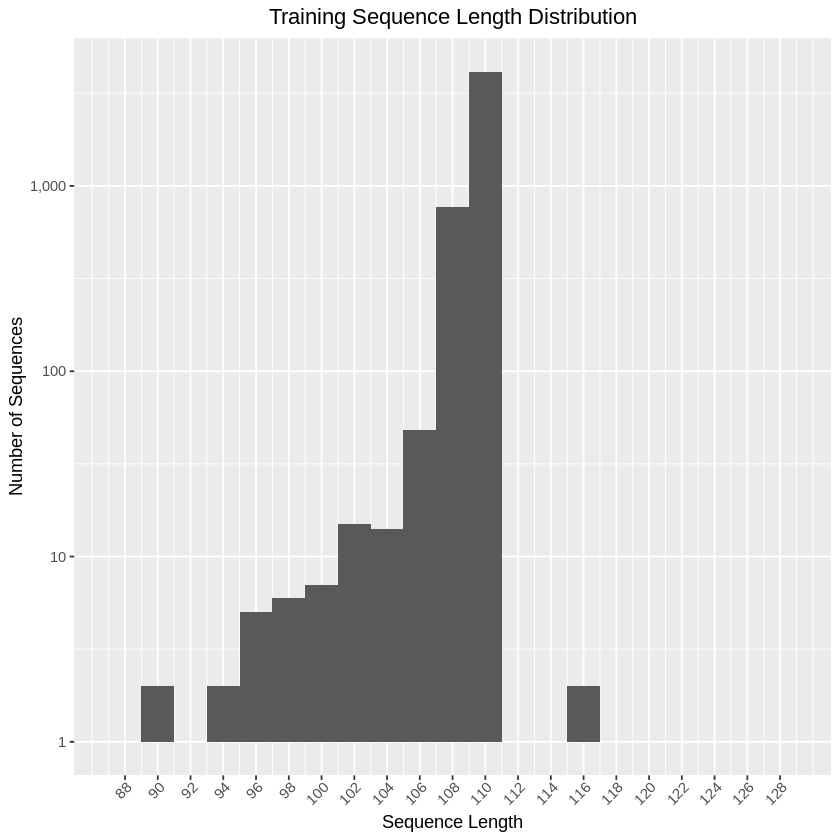

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 5 rows containing missing values (`geom_bar()`).”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”
Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing missing values (`geom_bar()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing missing values (`geom_bar()`).”
Saving 6.67 x 6.67 in image


[1] "Start:  2022-11-29 23:54:31  End:  2022-11-29 23:54:35  Difference:  3.65948295593262"


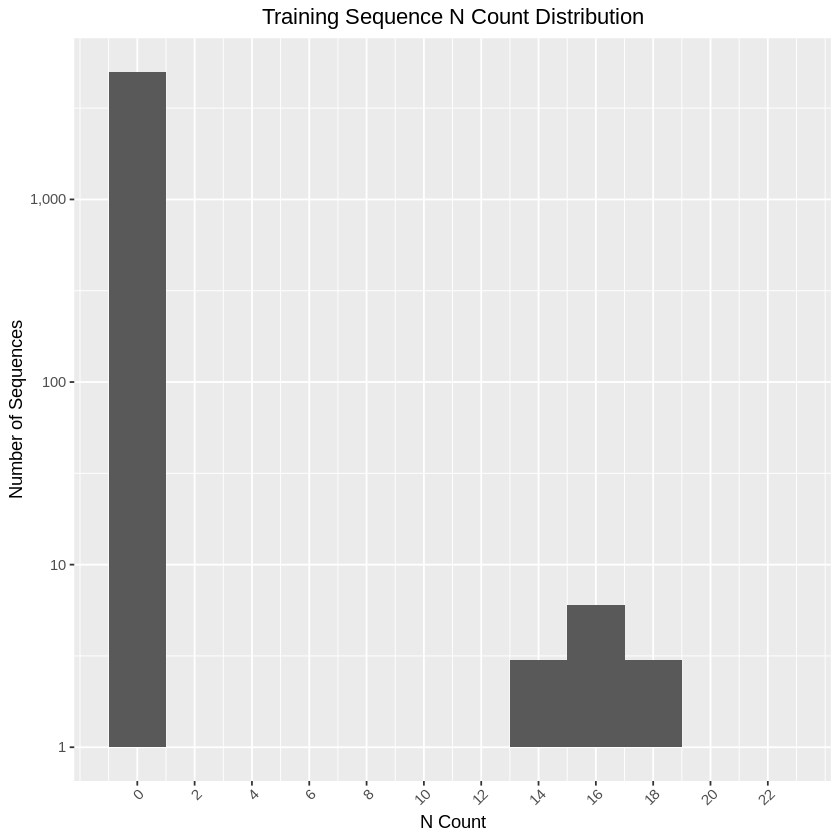

In [1]:
library(data.table)
library(stringr)
library(ggplot2)

start_time <- Sys.time()

DATA_DIR <- "./" #"/home/jgburk/PycharmProjects/IntroductionToDeepLearning/TF_Data/"
REAL_TRAIN_DATA_FN <- "train_sequences2.txt"

countn <- function(x){
  return (stringr::str_count(x,"N"))
}

real_train.df <- data.table::fread(paste(DATA_DIR,REAL_TRAIN_DATA_FN,sep=""))

colnames(real_train.df) <- c("Sequence","Expression") 

real_train.df$nchar <- sapply(real_train.df$Sequence,nchar)
real_train.df$nn <- sapply(real_train.df$Sequence,countn)

print(paste("MAX NCHAR:",max(real_train.df$nchar),sep=""))

ggplot(real_train.df, aes(real_train.df$nchar)) +
  geom_histogram(binwidth = 2) +
  scale_x_continuous(breaks = seq(from = min(real_train.df$nchar), to = max(real_train.df$nchar), by = 2)) +
  scale_y_log10(labels = scales::comma) +
  xlab("Sequence Length") +
  ylab("Number of Sequences") +
  ggtitle("Training Sequence Length Distribution") +
  theme(plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle=45,vjust =1.1,hjust = 1))

ggsave(filename=paste(DATA_DIR,"train_seq_nchar_plot.png",sep=""),device = "png")

ggplot(real_train.df, aes(real_train.df$nn)) +
  geom_histogram(binwidth = 2) +
  scale_x_continuous(breaks = seq(from = min(real_train.df$nn), to = max(real_train.df$nn), by = 2)) +
  scale_y_log10(labels = scales::comma) +
  xlab("N Count") +
  ylab("Number of Sequences") +
  ggtitle("Training Sequence N Count Distribution") +
  theme(plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle=45,vjust =1.1,hjust = 1))

ggsave(filename=paste(DATA_DIR,"train_seq_nn_plot.png",sep=""),device = "png")

# from http://www.hgmd.cf.ac.uk/docs/nuc_lett.html
# Nucleotide symbol 	Full Name
# A 	Adenine
# C 	Cytosine
# G 	Guanine
# T 	Thymine
# U 	Uracil
# R 	Guanine / Adenine (purine)
# Y 	Cytosine / Thymine (pyrimidine)
# K 	Guanine / Thymine
# M 	Adenine / Cytosine
# S 	Guanine / Cytosine
# W 	Adenine / Thymine
# B 	Guanine / Thymine / Cytosine
# D 	Guanine / Adenine / Thymine
# H 	Adenine / Cytosine / Thymine
# V 	Guanine / Cytosine / Adenine
# N 	Adenine / Guanine / Cytosine / Thymine

nn_no_outliers <- real_train.df$nn[real_train.df$nn > min(real_train.df$nn) & real_train.df$nn < max(real_train.df$nn)]
nn_range_rule_sd_est <- (max(nn_no_outliers) - min(nn_no_outliers))/4
nn_mean <- mean(nn_no_outliers)

NUM_SIM_SEQ_PER_TRAIN_SEQ <- 2

gen_sim_seqs <- function(real_seq,real_seq_len,nn_mean,nn_sd_est){
    utf8seq <- utf8ToInt(real_seq)
    utf8seq[sample(1:real_seq_len,
                   size=round(abs(rnorm(1,
                              mean = nn_mean,
                              sd = nn_sd_est))),
                   replace = FALSE)] <- utf8ToInt("N")
  return (intToUtf8(utf8seq))
}

for(i in 1:NUM_SIM_SEQ_PER_TRAIN_SEQ){
  sim_seq_col_name <- paste("sim_seq",i,sep="_")
  nchar_col_name <- paste("sim_seq",i,"nchar",sep="_")
  nn_col_name <- paste("sim_seq",i,"nn",sep="_")
  
  real_train.df[,sim_seq_col_name] <- mapply(gen_sim_seqs,
                                real_train.df$Sequence,
                                real_train.df$nchar,
                                nn_mean,
                                nn_range_rule_sd_est)
  
  real_train.df[,nchar_col_name] <- sapply(real_train.df[,..sim_seq_col_name],nchar)
  real_train.df[,nn_col_name] <- sapply(real_train.df[,..sim_seq_col_name],countn)
  
  ggplot(real_train.df, aes_string(nchar_col_name)) +
    geom_histogram(binwidth = 2) +
    scale_x_continuous(breaks = seq(from = min(real_train.df[,..nchar_col_name]), to = max(real_train.df[,..nchar_col_name]), by = 2)) +
    scale_y_log10(labels = scales::comma) +
    xlab("Sequence Length") +
    ylab("Number of Sequences") +
    ggtitle(paste("Simulated Sequence ",i," Length Distribution",sep="")) +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle=45,vjust =1.1,hjust = 1))
  
  ggsave(filename=paste(DATA_DIR,"sim_seq_",i,"_nchar_plot.png",sep=""),device = "png")
  
  ggplot(real_train.df, aes_string(nn_col_name)) +
    geom_histogram(binwidth = 2) +
    scale_x_continuous(breaks = seq(from = min(real_train.df[,..nn_col_name]), to = max(real_train.df[,..nn_col_name]), by = 2)) +
    scale_y_log10(labels = scales::comma) +
    xlab("N Count") +
    ylab("Number of Sequences") +
    ggtitle(paste("Simulated Sequence ",i," N Count Distribution",sep="")) +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle=45,vjust =1.1,hjust = 1))
  
  ggsave(filename=paste(DATA_DIR,"sim_seq_",i,"_nn_plot.png",sep=""),device = "png")
  
  write.table(data.frame("Simulated_Sequence" = real_train.df[,..sim_seq_col_name],
                         "Expression" = real_train.df$Expression),
              file=paste(DATA_DIR,"sim_seq_",i,"_",REAL_TRAIN_DATA_FN,sep=""),
              quote=FALSE,
              sep="\t",
              row.names = FALSE,
              col.names = FALSE)
}

end_time <- Sys.time()
print(paste(
  "Start: ",
  start_time,
  " End: ",
  end_time,
  " Difference: ",
  end_time - start_time
))